# Fractal Dimension and Lacunarity

Much of the code/theory is from: http://connor-johnson.com/2014/03/04/fractal-dimension-and-box-counting/

This notebook contains the prototype code for calculating the fractal dimension and lacunarity of a path in any positive integer dimension. It is tested on random walk data.

## Import Packages

In [50]:
import scipy.optimize
from pandas import Series, DataFrame
import statsmodels.formula.api as sm
import numpy as np, scipy, scipy.stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Generate Data

Generate a random walk of length *n* in *d* dimensions and plot it if it is 1, 2, or 3 dimensional.

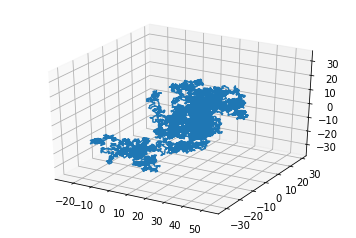

In [51]:
n = 10000
d = 3
start_pos = [0]*d
steps = np.random.rand(n - 1, len(start_pos)) * 2 - [[1]*len(start_pos)]*(n - 1)
random_walk = [start_pos]
for s in steps:
    random_walk.append(random_walk[-1] + s)
if d == 1 or d == 2:
    plt.plot(*np.transpose(random_walk))
if d == 3:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(*np.transpose(random_walk), label='parametric curve')

plt.show()

## Count Boxes

This function efficiently counts the boxes filled at a given scale by points in the path. Note tha this assumes a smooth, continuous path through space without jumps. The box counting will not interpolate between points at sufficiently small scales.

In [52]:
def count_boxes(data, scale):
    boxed_path = np.floor(np.divide(data, scale))
    unique = np.unique(boxed_path, axis=0)
    min_range = np.min(unique, axis=0)
    max_range = np.max(unique, axis=0)
    possible_boxes_in_range = np.prod(np.abs(np.subtract(min_range, max_range)))
    filled_boxes = len(unique)
    return filled_boxes

In addition to counting the boxes, if the scales being computed are too wide, we'll want to remove them from the estimate. Scales that are too large will result in only 1 or 2 boxes while scales that are too small will result in the number of boxes equaling the number of points. To combat this, we can filter the scales to be used according to the standard error of the log of the box counts. This removes the lower and upper asymptotes under many conditions (though it isn't perfect).

In [53]:
data = random_walk
scale_range = 20
r = np.array([2.0**(scale_range/2)/(2.0**i) for i in range(scale_range,0,-1)]) # Powers of 2
N = [ count_boxes( data, ri) for ri in r ]
rlog = np.log(r)
Nlog = np.log(N)
ste = np.std(Nlog)/np.sqrt(len(data))
indicies = [idx for idx, (a, b) in enumerate(zip(rlog, Nlog)) if (not b <= (min(Nlog) + ste) and not b >= (max(Nlog) - ste))]
N = np.take(N, indicies)
r = np.take(r, indicies)

## Fit Line

Next, we'll fit a linear trend to the log of the box count and scale parameters. The slope of this line is the fractal dimension while the intercept is the lacunarity.

In [57]:
def f( x, A, Df ):
    return Df * x + A
 
popt, pcov = scipy.optimize.curve_fit( f, np.log( 1./r ), np.log( N ) )
A, Df = popt

[ 8.55884247  1.62341496]


## Plot

We can plot the log-log plot of the scale and box count to see the fit. The slope will often be slightly underestimated and the intercept slightly overestimated due to the imperfect asymptote filter.

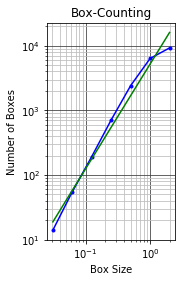

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot( 1./r, N, 'b.-' )
ax.plot( 1./r, np.exp(A)*1./r**Df, 'g', alpha=1.0 )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect(1)
plt.xlabel('Box Size')
plt.ylabel('Number of Boxes')
plt.grid(which='minor', ls='-', color='0.75')
plt.grid(which='major', ls='-', color='0.25')
plt.title('Box-Counting')

plt.show()

## Final Functions

Now, we can wrap all of the above functionality in some functions for convenience.

In [7]:
def generate_random_walk(n=100000, d=3):
    start_pos = [0]*d
    steps = np.random.rand(n - 1, len(start_pos)) * 2 - [[1]*len(start_pos)]*(n - 1)
    random_walk = [start_pos]
    for s in steps:
        random_walk.append(random_walk[-1] + s)
    return random_walk

def count_boxes(data, scale):
    boxed_path = np.floor(np.divide(data, scale))
    unique = np.unique(boxed_path, axis=0)
    filled_boxes = len(unique)
    return filled_boxes


def calculate_fd_and_lacunarity(data):
    scale_range = 20
    r = np.array([2.0 ** (scale_range / 2) / (2.0 ** i) for i in range(scale_range, 0, -1)])  # Powers of 2 around 0
    N = [count_boxes(data, ri) for ri in r]
    Nlog = np.log(N)
    ste = np.std(Nlog) / np.sqrt(len(data))
    indicies = [idx for idx, n in enumerate(Nlog) if (not n <= (min(Nlog) + ste) and not n >= (max(Nlog) - ste))]
    N = np.take(N, indicies)
    r = np.take(r, indicies)

    def linear_function(x, A, Df):
        return Df * x + A

    popt, pcov = scipy.optimize.curve_fit(linear_function, np.log(1. / r), np.log(N))
    lacunarity, fd = popt

    return fd, lacunarity

## Benchmarking

Finally, we can benchmark and see that the calculation is fairly efficient, with the curve fitting being the most expensive step (thus allowing the function to scale very well to longer paths).

0.0130000019073 seconds average runtime for n=1000, d=1, iters=25.
0.0168799972534 seconds average runtime for n=1000, d=2, iters=25.
0.0185999965668 seconds average runtime for n=1000, d=3, iters=25.
0.143839998245 seconds average runtime for n=10000, d=1, iters=25.
0.205760002136 seconds average runtime for n=10000, d=2, iters=25.
0.224279994965 seconds average runtime for n=10000, d=3, iters=25.
1.69515999794 seconds average runtime for n=100000, d=1, iters=25.
2.2307199955 seconds average runtime for n=100000, d=2, iters=25.
2.76119999886 seconds average runtime for n=100000, d=3, iters=25.


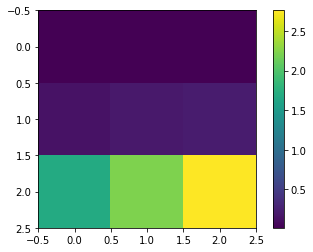

In [75]:
import time
import matplotlib.pyplot as plt

def time_function(iterations=100, n=100000, d=3):
    data = generate_random_walk(n=n, d=d)
    t0 = time.time()
    for i in range(0, iterations):
        fd, lac = calculate_fd_and_lacunarity(data)
    avg_time = (time.time()-t0)/iterations
    print('{0} seconds average runtime for n={1}, d={2}, iters={3}.'.format(str(avg_time), n, d, iterations))
    return avg_time

ns = [1000, 10000, 100000]
ds = [1, 2, 3]
results = [[time_function(iterations=25, n=n, d=d) for d in ds] for n in ns]
plt.imshow(results)
plt.colorbar()
plt.show()

## Scale Bounds Variability

Finally, we need to look at if the scale bounds vary significant across the sample. This is so we can decide a unified scale bounds for all participants.

In [10]:
import numpy as np
import scipy.optimize
def calculate_fd_and_lacunarity(data, indicies=None):
    scale_range = 20
    r = np.array([2.0 ** (scale_range / 2) / (2.0 ** i) for i in range(scale_range, 0, -1)])  # Powers of 2 around 0
    N = [count_boxes(data, ri) for ri in r]
    Nlog = np.log(N)
    ste = np.std(Nlog) / np.sqrt(len(data))
    if indicies is None:
        indicies = [idx for idx, n in enumerate(Nlog) if (not n <= (min(Nlog) + ste) and not n >= (max(Nlog) - ste))]
    N = np.take(N, indicies)
    r = np.take(r, indicies)

    def linear_function(x, A, Df):
        return Df * x + A

    popt, pcov = scipy.optimize.curve_fit(linear_function, np.log(1. / r), np.log(N))
    lacunarity, fd = popt

    return fd, lacunarity, indicies

In [12]:
from cogrecon.core.data_flexing.time_travel_task.time_travel_task_binary_reader import find_data_files_in_directory, read_binary_file
search_directory=r'C:\Users\Kevin\Documents\GitHub\msl-iposition-pipeline\examples\saved_data\Paper Data (cleaned)'
file_regex="\d\d\d_\d_1_\d_\d\d\d\d-\d\d-\d\d_\d\d-\d\d-\d\d.dat"
output_path='time_travel_task_navigation_summary.csv'
last_pilot_id=20
temporal_boundary_regions = [[[-100, 15]], [[15, 30]], [[30, 45]], [[45, 100]]]

files = find_data_files_in_directory(search_directory, file_regex=file_regex)

2018-01-29 17:09:34 DESKTOP-LKC15NF root[41200] INFO Found 172 data files in 0.0620000362396 seconds.


In [13]:
len(files)

172

In [ ]:
from tqdm import tqdm

# Precalculate FD/Lacunarity Thresholds
index0 = []
index1 = []
index2 = []
for path in tqdm(files):
    iterations = read_binary_file(path)
    
    timeline = [[i['time_val']] for i in iterations]
    spaceline = [[i['x'], i['z']] for i in iterations]
    spacetimeline = [[i['x'], i['z'], i['time_val']] for i in iterations]

    fd_t, lac_t, idxs0 = calculate_fd_and_lacunarity(timeline)
    fd_s, lac_s, idxs1 = calculate_fd_and_lacunarity(spaceline)
    fd_st, lac_st, idxs2 = calculate_fd_and_lacunarity(spacetimeline)
    index0.append(idxs0)
    index1.append(idxs1)
    index2.append(idxs2)

In [25]:
unique0 = [list(x) for x in list(set(frozenset(item) for item in index0))]
unique1 = [list(x) for x in list(set(frozenset(item) for item in index1))]
unique2 = [list(x) for x in list(set(frozenset(item) for item in index2))]

print(unique0)
print(unique1)
print(unique2)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]


So we will use the window [1,2...,14] as it is the most conservative window for spacetime, but because all participants have identical windows for space and time only, we'll use those. It is reasonable to expect each of these to have different scale parameters as they are in different units.